In [1]:
import weightwatcher
import transformers

import sys
from pathlib import Path
from time import time

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset

from weightwatcher import WeightWatcher

from matplotlib import pyplot as plt


Running on macOS.


PyTorch is available but CUDA is not. Defaulting to NumPy for SVD
Import error , reetting to svd accurate methods


Running on macOS.


# Use SETOL paper experimental code

https://github.com/charlesmartin14/SETOL_experiments/

You may need to modify the code to run on MacOS

In [2]:
!pwd; ls  *py

/Users/charleshmartin/Desktop/work/lr-experiments/SETOL_experiments/pytorch
models.py            shuffled_accuracy.py utils.py
pildataset.py        train_models.py
plot_utils.py        trainer.py


In [75]:
from utils import last_epoch
from trainer_macos import Trainer, PreLoader
from pildataset import PILDataSet
from models import MLP3

# Set up PyTorch; 

Not using DETERMINISTIC, this is just a demo

In [4]:
#NOTE: changing this value requires resetting the notebook kernel.
DETERMINISTIC = False
#evice = torch.device("cuda" if torch.cuda.is_available() else "CPU")

device = torch.device("mps")  # Use Metal backend
tensor = torch.randn(2, 2).to(device)  # Move tensor to MPS
print(tensor)

if DETERMINISTIC:
    import random
    import os

    torch.use_deterministic_algorithms(True)
    def reset_random_seeds(seed_value=1):
        os.environ['PYTHONHASHSEED']=str(seed_value)
        torch.manual_seed(0)
        np.random.seed(seed_value)
        random.seed(seed_value)

    reset_random_seeds()
else:
    reset_random_seeds = lambda: None

tensor([[-1.1546, -0.1211],
        [-1.8866, -1.2132]], device='mps:0')


In [5]:
import torch; print('MPS Available:', torch.backends.mps.is_available()); print('MPS Built:', torch.backends.mps.is_built())

MPS Available: True
MPS Built: True


# Create 3-Layer MLP, Describe

- later\_id: WW specific id

- Aspect Ratio: $Q = N/M \ge 1$
- Receptive Field size: (1 for Linear) 
$\text{rf} \ge 1$

In [6]:
from copy import deepcopy

m = MLP3(widths=(300, 100), H=28, W=28, C=1)
m0 = deepcopy(m)

In [7]:
import weightwatcher as ww
watcher = ww.WeightWatcher(model=m0)
watcher.describe()

,layer_id,name,M,N,Q,layer_type,longname,num_evals,rf
0,3,Linear,300,784,2.613333,dense,op.1,300,1
1,5,Linear,100,300,3.000000,dense,op.3,100,1
2,7,Linear,10,100,10.000000,dense,op.5,10,1


## $\mathbf{W}$ is *only weakly* Heavy Tailed (HT)

- The elements can be fit to a Laplacian

- The is a weak long tail

- This HT-ness can not be seen with RMT 

# Random Matrices $\mathbf{W}^{init}$

or

### You can fit anything to a Power Law

Pay attention to

- *Randomized ESD*: $\;\;\text{rand}(\mathbf{W}^{init})$
- *Marchenko Pastur (MP) Fit*

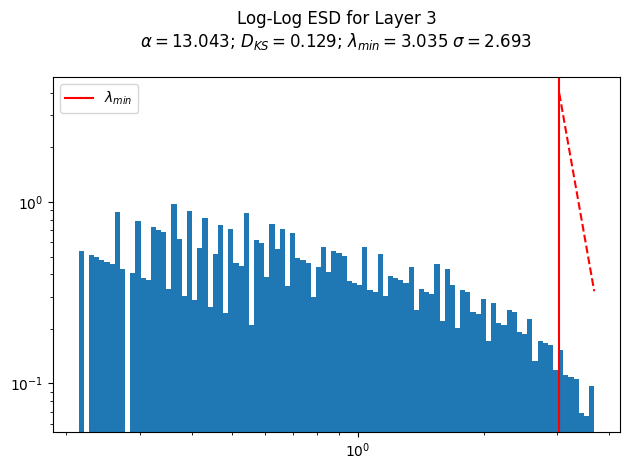

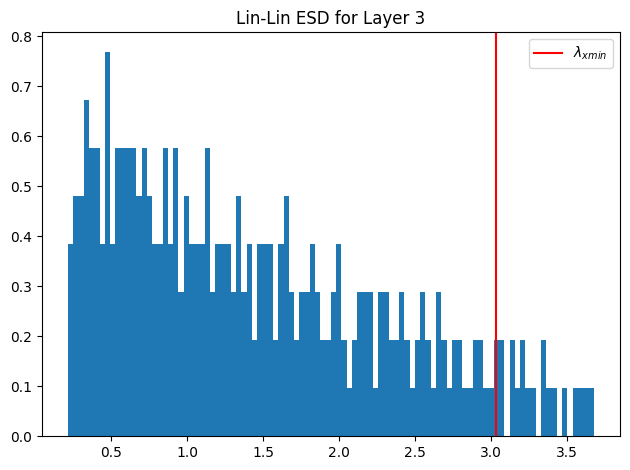

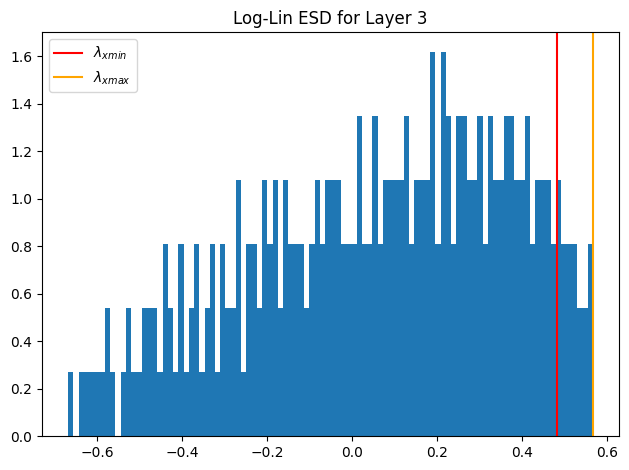

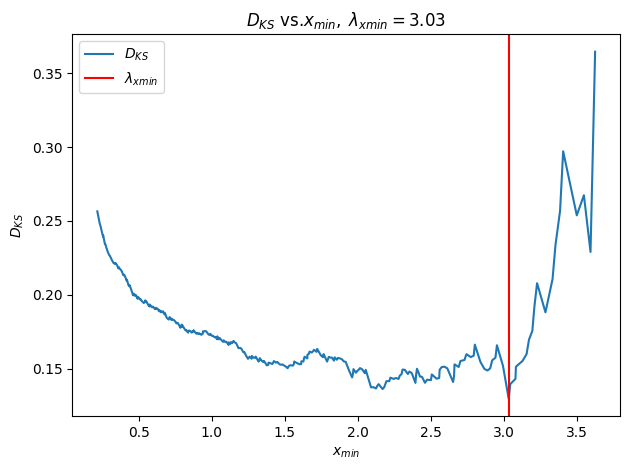

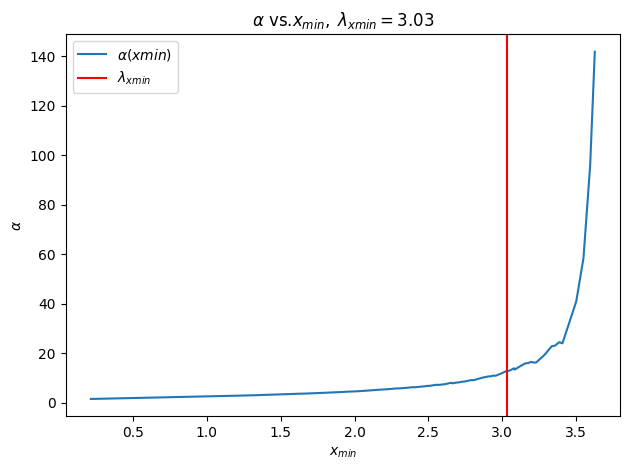

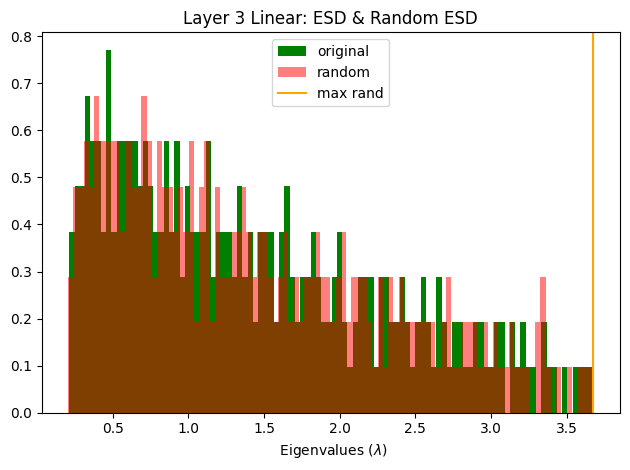

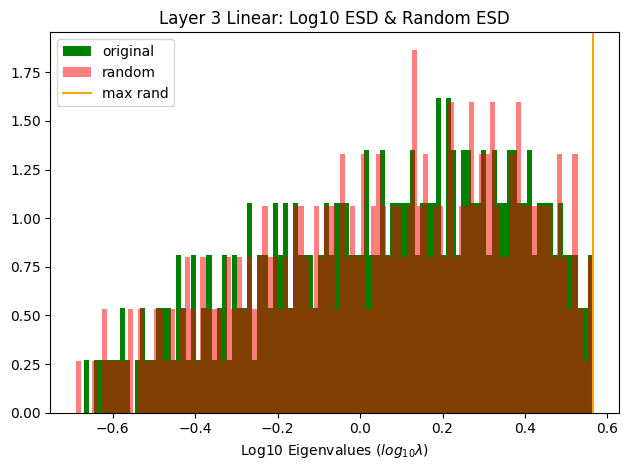

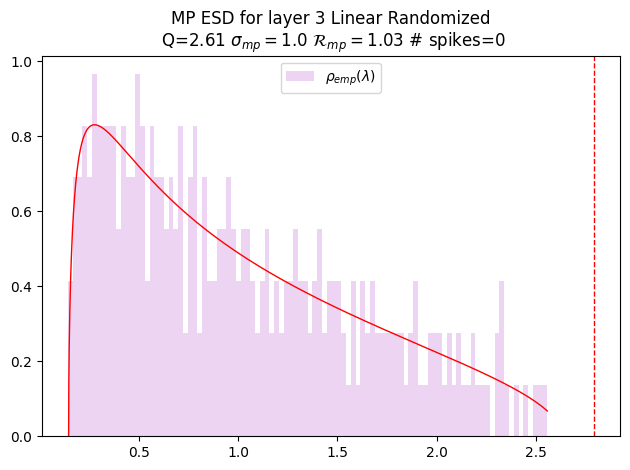

,layer_id,name,D,M,N,Q,alpha,alpha_weighted,entropy,has_esd,...,stable_rank,status,sv_max,sv_min,warning,weak_rank_loss,ww_maxdist,ww_softrank,xmax,xmin
0,3,Linear,0.129451,300,784,2.613333,13.043302,7.379263,0.96656,True,...,117.06478,success,1.918119,0.463099,under-trained,0,-0.075026,1.020392,3.679181,3.034968


<Figure size 640x480 with 0 Axes>

In [8]:
watcher.analyze(layers=[3],plot=True, randomize=True)

### Train MLP3 on MNIST using SETOL_Experiments code

- set individual layer learning rates (lr)
- stop (checkpoint) and start over
- save all data
- runs weightwatcher, returns a details dataframe


#### Main training loop
<code>
t.train_loop("SETOL/TEST", 0, 20, loader, LR=LRs, loss="CCE")
</code>
<br>

Parameters

- **directory**  
  The path to the folder where relevant files (e.g., models, logs) will be saved or accessed.

- **start_epoch**  
  The initial epoch number from which training or evaluation should begin.

- **stop_epoch**  
  The final epoch number at which the process should end.

- **learning_rates**  
  A list or schedule of learning rates to be applied during training.

- **loss**  
  The loss function or criterion used to evaluate and guide model optimization.



Here, I train the same model 5 times with different starting points to get some error bars

### WeightWatcher : advanced options 

`details = self.watcher.analyze(min_evals=50, plot=False, randomize=True, fix_fingers='clip_xmax', detX=True, vectors=True)`

Parameters

- **min_evals**  
  You need at least M=50 or so eigenvalues to get a good powerlaw fit
  (this will ignore the last layer where M=10 for MNIST)

- **randomize**
   Computes rand_distance metric, and checks for correlation traps
  

- **fix_fingers='clip_xmax'**
   Corrects for DragonKings

- **detX**
   Turns on the new SETOL metrics that checks for the DetX/TraceLog condition
   (i.e., the Exact Wilson Renormalization Group)


- **vectors**
   Computes vector localization metrics *(see HTSR/JMLR paper)

In [9]:
TRAIN = PILDataSet(True, DS="MNIST")
TEST  = PILDataSet(False, DS="MNIST")
loader = PreLoader("MNIST", TRAIN, TEST, batch_size=16)

print(f"DETERMINISTIC set to {DETERMINISTIC}")
all_details = []
lr = 16
LRs = [0.01*lr, 0.01*lr, 0.01*lr]

start_epoch = 0
stop_epoch = 50

for num in range(1):
    print(num)
    reset_random_seeds()

    m = MLP3(widths=(300, 100), H=28, W=28, C=1)
    
    t = Trainer(m)
    t.train_loop("SETOL/TEST", start_epoch, stop_epoch, loader, LR=LRs, loss="CCE")
    print("\n")
    all_details.append(t.details)

#LRs = [0.01, 0.02, 0.01]
#t.train_loop("SETOL/TEST", 2, 4, loader, LR=LRs, loss="CCE")
#print("\n")


#print(t.details)


DETERMINISTIC set to False
0
SETOL/TEST run 0 epoch 1 loss 0.2099 train accuracy 0.9351 test accuracy 0.9681 18.92 seconds	 alpha 1 2.664	 alpha 2 2.626
SETOL/TEST run 0 epoch 2 loss 0.0906 train accuracy 0.9725 test accuracy 0.9720 12.60 seconds	 alpha 1 2.423	 alpha 2 2.389
SETOL/TEST run 0 epoch 3 loss 0.0616 train accuracy 0.9804 test accuracy 0.9731 18.62 seconds	 alpha 1 2.317	 alpha 2 2.317
SETOL/TEST run 0 epoch 4 loss 0.0464 train accuracy 0.9849 test accuracy 0.9783 15.94 seconds	 alpha 1 2.228	 alpha 2 2.287
SETOL/TEST run 0 epoch 5 loss 0.0380 train accuracy 0.9879 test accuracy 0.9594 12.91 seconds	 alpha 1 2.171	 alpha 2 2.242
SETOL/TEST run 0 epoch 6 loss 0.0282 train accuracy 0.9908 test accuracy 0.9777 13.51 seconds	 alpha 1 2.130	 alpha 2 2.263
SETOL/TEST run 0 epoch 7 loss 0.0223 train accuracy 0.9927 test accuracy 0.9801 15.78 seconds	 alpha 1 2.096	 alpha 2 2.218
SETOL/TEST run 0 epoch 8 loss 0.0191 train accuracy 0.9938 test accuracy 0.9806 13.74 seconds	 alpha 1 

### 1 Details DataFrame

In [10]:
df0 = all_details[0]
df0[['epoch', 'layer_id','raw_delta_W', 'raw_delta_b']]

,epoch,layer_id,raw_delta_W,raw_delta_b
0,0,3,0.000000,0.000000
1,0,5,0.000000,0.000000
2,1,3,13.779905,0.959116
3,1,5,7.190384,0.676733
4,2,3,17.237972,1.248802
...,...,...,...,...
97,48,5,19.632900,2.368811
98,49,3,36.298191,2.963643
99,49,5,19.634794,2.369289
100,50,3,36.299385,2.963572


### Vector metrics

The **mean* vector entropy and localization metrics are provided for the power law bulk and  tail metrics <br>
(as described in the HTSR JMLR paper: https://jmlr.org/papers/v22/20-410.html )

- **vec_entropy:** vector entropy

- **loc_ratio:** localziation ratio

- **part_ratio:** participation ratio

<pre>
  'bulk_mean_loc_ratio', 'bulk_mean_part_ratio', 'bulk_mean_vec_entropy', 'bulk_var_loc_ratio', 'bulk_var_part_ratio', 'bulk_var_vec_entropy',
       

 'tail_mean_loc_ratio', 'tail_mean_part_ratio', 'tail_mean_vec_entropy', 'tail_var_loc_ratio', 'tail_var_part_ratio', 'tail_var_vec_entropy',
</pre>

<hr>


In [11]:
df0.columns

Index(['layer_id', 'name_x', 'D', 'M_x', 'N_x', 'Q', 'alpha', 'alpha_weighted',
       'bulk_mean_loc_ratio', 'bulk_mean_part_ratio', 'bulk_mean_vec_entropy',
       'bulk_var_loc_ratio', 'bulk_var_part_ratio', 'bulk_var_vec_entropy',
       'detX_num', 'detX_val', 'detX_val_unrescaled', 'entropy', 'has_esd',
       'lambda_max', 'layer_type', 'log_alpha_norm', 'log_norm',
       'log_spectral_norm', 'longname_x', 'matrix_rank', 'max_rand_eval',
       'norm', 'num_evals', 'num_fingers', 'num_pl_spikes', 'rand_W_scale',
       'rand_bulk_max', 'rand_bulk_min', 'rand_distance', 'rand_mp_softrank',
       'rand_num_spikes', 'rand_sigma_mp', 'rank_loss', 'raw_alpha', 'rf',
       'sigma', 'spectral_norm', 'stable_rank', 'status', 'sv_max', 'sv_min',
       'tail_mean_loc_ratio', 'tail_mean_part_ratio', 'tail_mean_vec_entropy',
       'tail_var_loc_ratio', 'tail_var_part_ratio', 'tail_var_vec_entropy',
       'warning', 'weak_rank_loss', 'ww_maxdist', 'ww_softrank', 'xmax',
       'xmin', 

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metric(all_details, metric='entropy', exclude_epoch_0=True, save=True):
    """
    Plots the given metric over epochs with error bars.
    
    Special Cases:
    -------------
    1) metric == 'loss':
       - Only use layer_id = 3
       - Plot train_loss, test_loss on the same figure with error bars
       - Y-axis label: "Loss"
    2) metric == 'accuracy':
       - Only use layer_id = 3
       - Plot train_acc, test_acc on the same figure with error bars
       - Y-axis label: "Accuracy"
    3) Otherwise (e.g. 'entropy', 'alpha', etc.):
       - Plot for layer_id in {3: 'FC1', 5: 'FC2'} with error bars
       - If metric == 'alpha', add a red dashed line at y=2.0
       - Y-axis label: f"Mean {metric.capitalize()}"
       
    Parameters:
    -----------
    all_details : list of pd.DataFrame
        List containing multiple runs of the dataset.
    metric : str
        The metric to plot (e.g., 'loss', 'accuracy', 'entropy', 'alpha').
    exclude_epoch_0 : bool
        Whether to exclude epoch 0 (default=True).
    save : bool
        Whether to save the plot as a PNG file named '{metric}.png' (default=True).
    
    Returns:
    --------
    None
        Displays the plot and optionally saves it as a PNG.
    """

    # ----------------------------------
    # 1. Combine all runs into one DataFrame
    # ----------------------------------
    df_all = pd.concat(all_details, keys=range(len(all_details)))
    df_all = df_all.reset_index(level=0).rename(columns={'level_0': 'run_id'})

    # Optionally filter out epoch 0
    if exclude_epoch_0:
        df_all = df_all[df_all['epoch'] != 0]

    # Create a figure/axes for plotting
    fig, ax = plt.subplots()

    # ----------------------------------
    # 2. Handle special cases: 'loss' or 'accuracy'
    # ----------------------------------
    if metric == 'loss':
        # Only layer_id=3
        df_layer3 = df_all[df_all['layer_id'] == 3]

        # Group by epoch and compute mean/std for train_loss, test_loss
        df_mean = df_layer3.groupby('epoch').agg(
            train_mean=('train_loss', 'mean'),
            train_std=('train_loss', 'std'),
            test_mean=('test_loss', 'mean'),
            test_std=('test_loss', 'std')
        ).reset_index()

        # Plot Train, Test
        ax.errorbar(df_mean['epoch'], df_mean['train_mean'], yerr=df_mean['train_std'],
                    fmt='o-', capsize=3, markersize=4, label='Train')
        ax.errorbar(df_mean['epoch'], df_mean['test_mean'],  yerr=df_mean['test_std'],
                    fmt='o-', capsize=3, markersize=4, label='Test')

        ax.set_ylabel("Loss")

        # Determine x-ticks
        epochs = sorted(df_mean['epoch'].unique())
        if len(epochs) >= 2:
            tick_positions = [epochs[0]] + list(epochs[1:-1]) + [epochs[-1]]
        else:
            tick_positions = epochs
        ax.set_xticks(tick_positions)

    elif metric == 'accuracy':
        # Only layer_id=3
        df_layer3 = df_all[df_all['layer_id'] == 3]

        # Group by epoch and compute mean/std for train_acc, test_acc
        df_mean = df_layer3.groupby('epoch').agg(
            train_mean=('train_acc', 'mean'),
            train_std=('train_acc', 'std'),
            test_mean=('test_acc', 'mean'),
            test_std=('test_acc', 'std')
        ).reset_index()

        # Plot Train, Test
        ax.errorbar(df_mean['epoch'], df_mean['train_mean'], yerr=df_mean['train_std'],
                    fmt='o-', capsize=3, markersize=4, label='Train')
        ax.errorbar(df_mean['epoch'], df_mean['test_mean'],  yerr=df_mean['test_std'],
                    fmt='o-', capsize=3, markersize=4, label='Test')

        ax.set_ylabel("Accuracy")

        # Determine x-ticks
        epochs = sorted(df_mean['epoch'].unique())
        if len(epochs) >= 2:
            tick_positions = [epochs[0]] + list(epochs[1:-1]) + [epochs[-1]]
        else:
            tick_positions = epochs
        ax.set_xticks(tick_positions)

    # ----------------------------------
    # 3. Default (e.g., 'entropy', 'alpha', etc.)
    # ----------------------------------
    else:
        # Group by epoch, layer_id, compute mean/std for the chosen metric
        df_mean = df_all.groupby(['epoch', 'layer_id']).agg(
            metric_mean=(metric, 'mean'),
            metric_std=(metric, 'std')
        ).reset_index()

        # Plot each layer
        layer_labels = {3: 'FC1', 5: 'FC2'}
        for layer, group in df_mean.groupby('layer_id'):
            label = layer_labels.get(layer, f'Layer {layer}')
            ax.errorbar(group['epoch'], group['metric_mean'], yerr=group['metric_std'],
                        fmt='o-', capsize=3, markersize=4, label=label)

        # If metric == 'alpha', add a horizontal red dashed line at y=2.0
        if metric.lower() == 'alpha':
            ax.axhline(y=2.0, color='red', linestyle='dashed', linewidth=1.5, label="y=2.0")

        ax.set_ylabel(f"Mean {metric.capitalize()}")

        # Determine x-ticks
        epochs = sorted(df_mean['epoch'].unique())
        if len(epochs) >= 2:
            tick_positions = [epochs[0]] + list(epochs[1:-1]) + [epochs[-1]]
        else:
            tick_positions = epochs
        ax.set_xticks(tick_positions)

    # ----------------------------------
    # 4. Common formatting and saving
    # ----------------------------------
    ax.set_xlabel("Epoch")
    ax.set_title(f"MLP3 trained on MNIST: {metric}")
    ax.legend(title="Data Split" if metric in ['loss','accuracy'] else "Layer ID")
    
    # Force integer ticks on the y-axis
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Save and show
    if save:
        filename = f"{metric}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {filename}")

    plt.show()

## Loss and Accuracy

Plot saved as loss.png


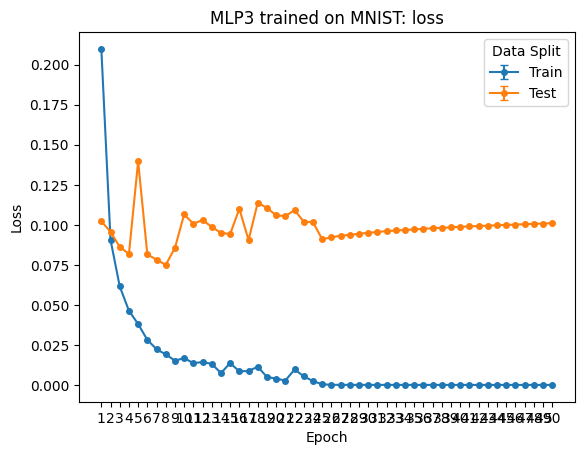

Plot saved as accuracy.png


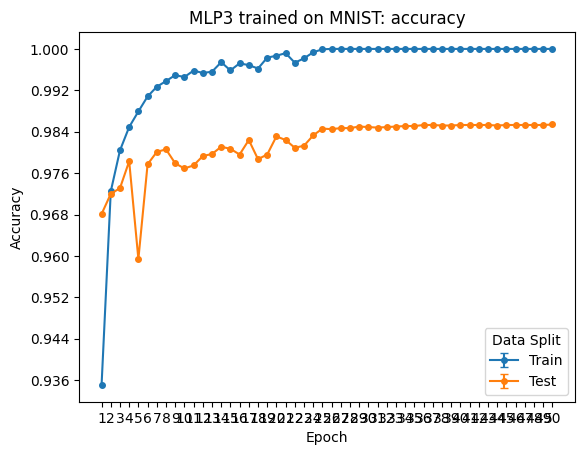

In [27]:
plot_metric(all_details, metric='loss')#, exclude_epoch_0=False)  # Includes epoch 0
plot_metric(all_details, metric='accuracy')  # Does not save the plot

## $\mathbf{W}$ is only *very weakly* Heavy Tailed Elementwise

- Appears to decay slower than Laplacian

- But also notice the cusp region is hard to fit

In [29]:
watcher = ww.WeightWatcher(model=m)
W3 = watcher.get_Weights(layer=3)[0]
print(W3.shape)

(300, 784)


### Plot $\rho(W_{i,j})$ and fit to Laplacian

Fitted Laplace parameters: loc=-0.01, scale=0.06


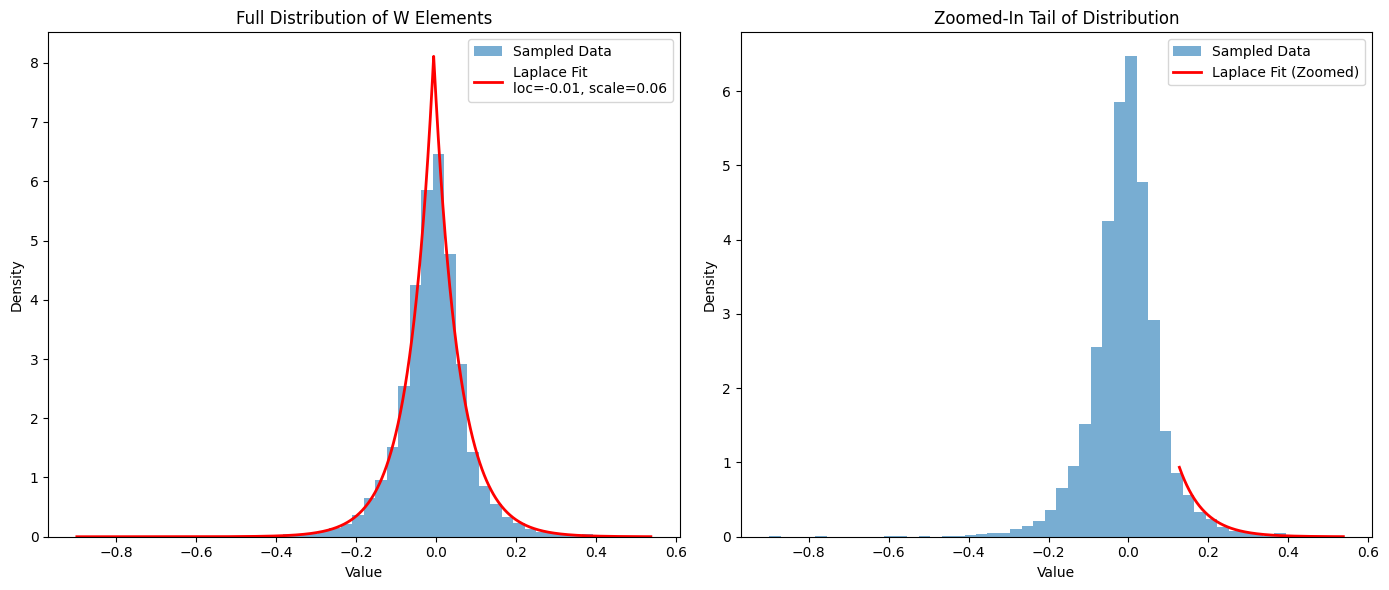

In [31]:
### import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace


W = W3

# Sample a subset of elements from W to speed up the analysis
num_samples = 10000  # adjust as needed
flat_W = W.ravel()
indices = np.random.choice(flat_W.shape[0], size=num_samples, replace=False)
sampled = flat_W[indices]

# Fit a Laplacian distribution to the sampled data
loc, scale = laplace.fit(sampled)
print(f"Fitted Laplace parameters: loc={loc:.2f}, scale={scale:.2f}")

# Create x values for plotting the fitted Laplace PDF
x_vals = np.linspace(np.min(sampled), np.max(sampled), 1000)
pdf_vals = laplace.pdf(x_vals, loc=loc, scale=scale)

# Plot full distribution and Laplace fit
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(sampled, bins=50, density=True, alpha=0.6, label='Sampled Data')
plt.plot(x_vals, pdf_vals, 'r-', lw=2, label=f'Laplace Fit\nloc={loc:.2f}, scale={scale:.2f}')
plt.title('Full Distribution of W Elements')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Zoom in on the tail region (e.g., the 95th percentile and above)
lower_bound = np.percentile(sampled, 95)
x_vals_zoom = np.linspace(lower_bound, np.max(sampled), 1000)
pdf_vals_zoom = laplace.pdf(x_vals_zoom, loc=loc, scale=scale)

plt.subplot(1, 2, 2)
plt.hist(sampled, bins=50, density=True, alpha=0.6, label='Sampled Data')
plt.plot(x_vals_zoom, pdf_vals_zoom, 'r-', lw=2, label='Laplace Fit (Zoomed)')
plt.title('Zoomed-In Tail of Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

### Zoom in on tail region of $\rho(W_{i,j})$

Fitted Laplace parameters: loc=-0.01, scale=0.06


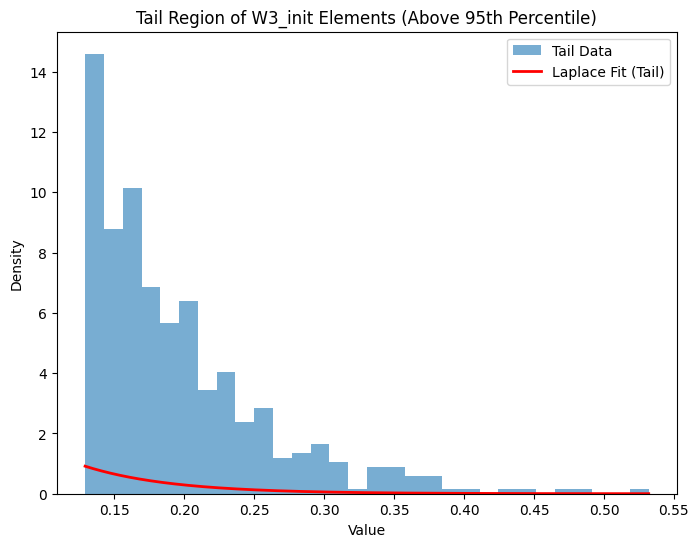

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace


# Flatten the matrix and sample a subset of elements
num_samples = 10000
flat_W = W.ravel()
indices = np.random.choice(flat_W.shape[0], size=num_samples, replace=False)
sampled = flat_W[indices]

# Fit a Laplacian distribution to the entire sampled data
loc, scale = laplace.fit(sampled)
print(f"Fitted Laplace parameters: loc={loc:.2f}, scale={scale:.2f}")

# Define the tail region: only values above the 95th percentile
tail_lower_bound = np.percentile(sampled, 95)
tail_sampled = sampled[sampled >= tail_lower_bound]

# Create x values for the tail region only
x_vals_tail = np.linspace(tail_lower_bound, np.max(tail_sampled), 1000)
pdf_vals_tail = laplace.pdf(x_vals_tail, loc=loc, scale=scale)

# Plot the tail region and the Laplace fit
plt.figure(figsize=(8, 6))
plt.hist(tail_sampled, bins=30, density=True, alpha=0.6, label='Tail Data')
plt.plot(x_vals_tail, pdf_vals_tail, 'r-', lw=2, label='Laplace Fit (Tail)')
plt.title('Tail Region of W3_init Elements (Above 95th Percentile)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

##  The HT-ness in $\text{rand}(\mathbf{W})$ can be detected with RMT

#### WW options
 - randomize=True

### Notice

-  $\alpha < 2$

- We do see what looks like a small 'Correlation Trap'

- This is not the driving element of generalization

- Usually associated with *decreased* test accuracies / overfitting


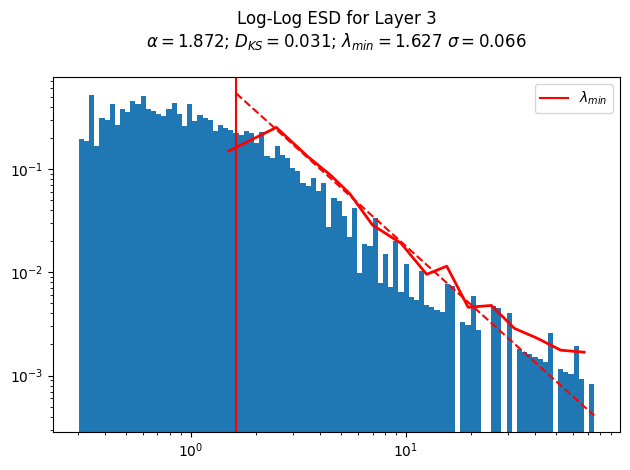

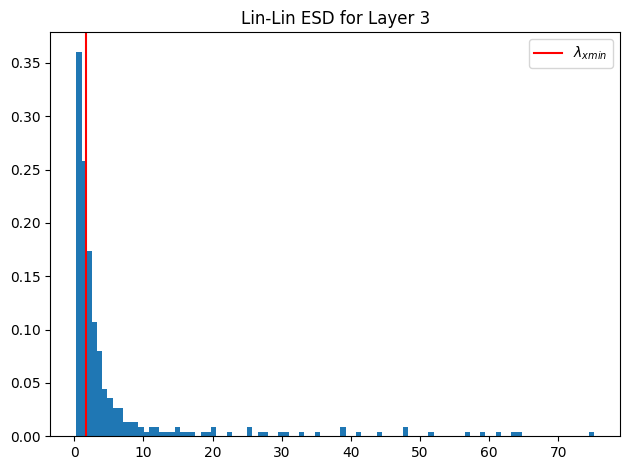

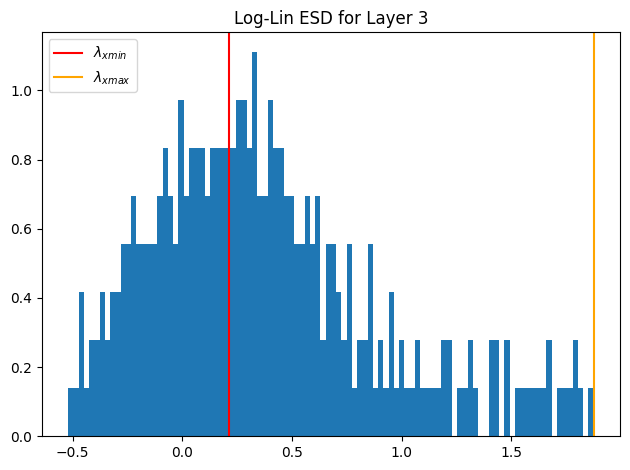

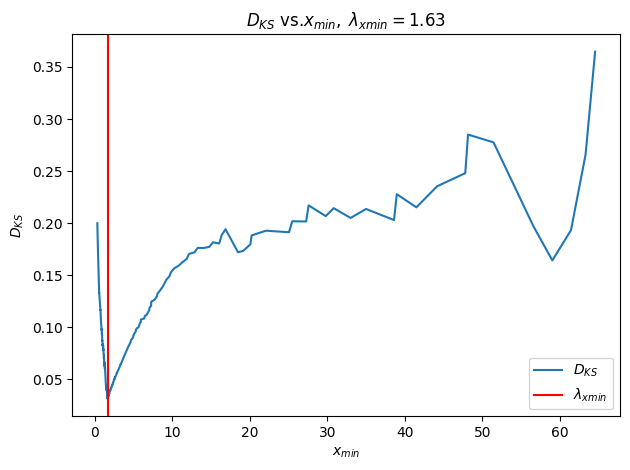

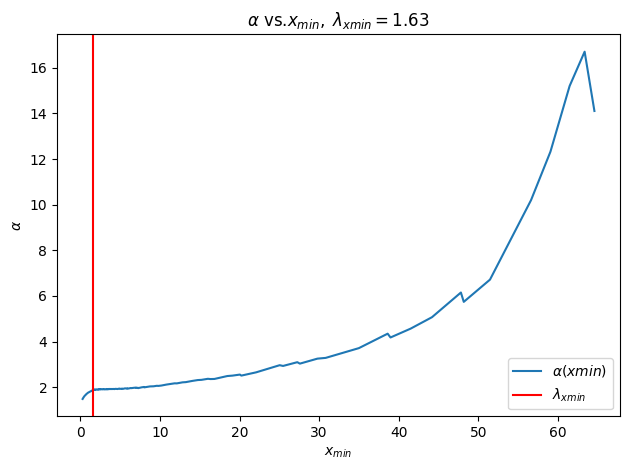

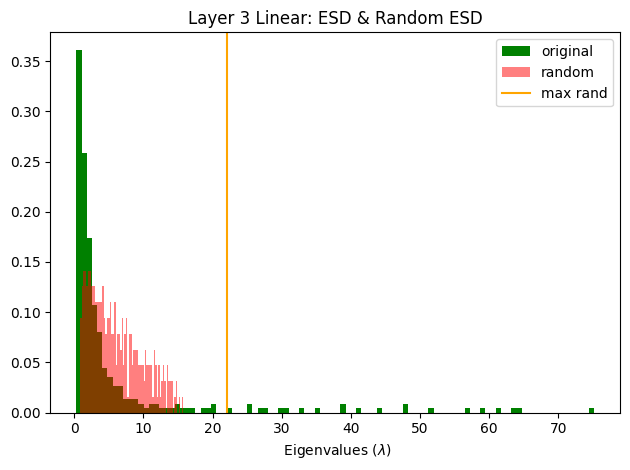

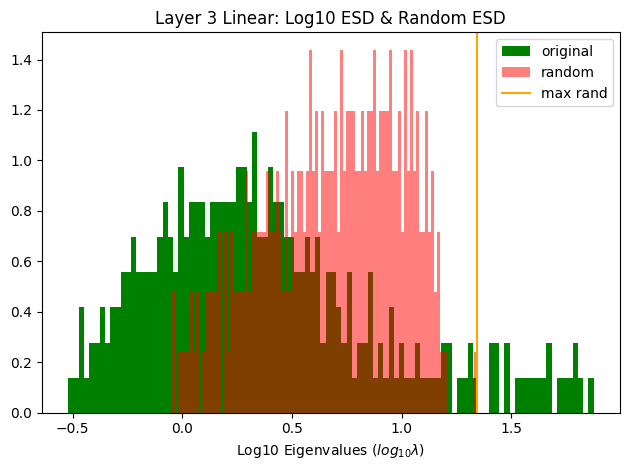

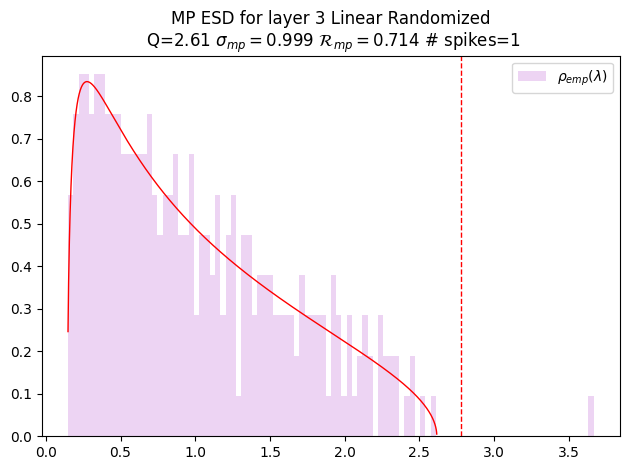

,layer_id,name,D,M,N,Q,alpha,alpha_weighted,entropy,has_esd,...,stable_rank,status,sv_max,sv_min,warning,weak_rank_loss,ww_maxdist,ww_softrank,xmax,xmin
0,3,Linear,0.031085,300,784,2.613333,1.87223,3.512647,0.829337,True,...,24.056563,success,8.671449,0.549065,over-trained,0,54.266567,0.278313,75.194036,1.626666


<Figure size 640x480 with 0 Axes>

In [54]:
watcher.analyze(layers=[3], plot=True, randomize=True,)

# WeightWatcher layer quality metrics

<hr>


### Distance from Init (elementwise)

$$\Vert \mathbf{W}-\mathbf{W}^{init}\Vert_{F} = \sqrt{\sum_{i,j}W_{i,j}-W_{i,j}^{init}}$$

#### Useful ?:  
you can see when learning staturates ? <br>

#### But what about: 

   - **Overfitting** ?
   
   - **Grokking** ?


  



Plot saved as raw_delta_W.png


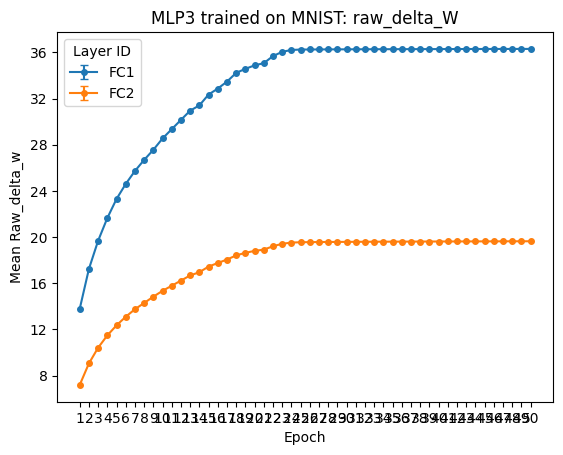

Plot saved as raw_delta_b.png


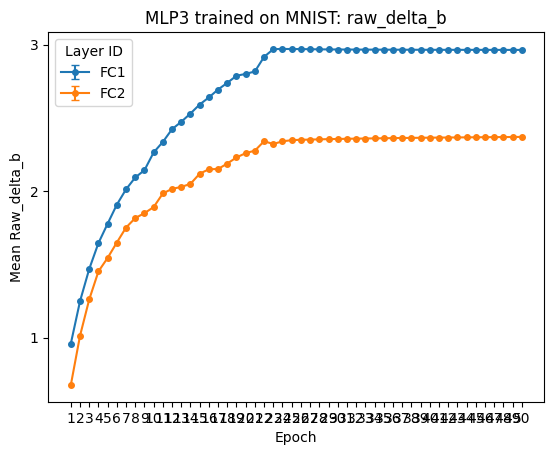

In [26]:
plot_metric(all_details, metric='raw_delta_W') 
plot_metric(all_details, metric='raw_delta_b')  

## Dataframe Columns

In [48]:
df0.columns

Index(['layer_id', 'name_x', 'D', 'M_x', 'N_x', 'Q', 'alpha', 'alpha_weighted',
       'bulk_mean_loc_ratio', 'bulk_mean_part_ratio', 'bulk_mean_vec_entropy',
       'bulk_var_loc_ratio', 'bulk_var_part_ratio', 'bulk_var_vec_entropy',
       'detX_num', 'detX_val', 'detX_val_unrescaled', 'entropy', 'has_esd',
       'lambda_max', 'layer_type', 'log_alpha_norm', 'log_norm',
       'log_spectral_norm', 'longname_x', 'matrix_rank', 'max_rand_eval',
       'norm', 'num_evals', 'num_fingers', 'num_pl_spikes', 'rand_W_scale',
       'rand_bulk_max', 'rand_bulk_min', 'rand_distance', 'rand_mp_softrank',
       'rand_num_spikes', 'rand_sigma_mp', 'rank_loss', 'raw_alpha', 'rf',
       'sigma', 'spectral_norm', 'stable_rank', 'status', 'sv_max', 'sv_min',
       'tail_mean_loc_ratio', 'tail_mean_part_ratio', 'tail_mean_vec_entropy',
       'tail_var_loc_ratio', 'tail_var_part_ratio', 'tail_var_vec_entropy',
       'warning', 'weak_rank_loss', 'ww_maxdist', 'ww_softrank', 'xmax',
       'xmin', 

## Simple Norms 

depend only on layer eight-matrix elements $W_{i,j}$


#### dataframe columns
- **norm**: Frobenius Norm $\;\;\Vert \mathbf{W} \Vert_{F}:=\sqrt{\sum W_{ij}^{2}}$

- **log_norm**: Log (base 10) Frobenius Norm $\;\;\log_{10}\Vert \mathbf{W} \Vert_{F}$


Not very informative
<hr>


Plot saved as raw_delta_W.png


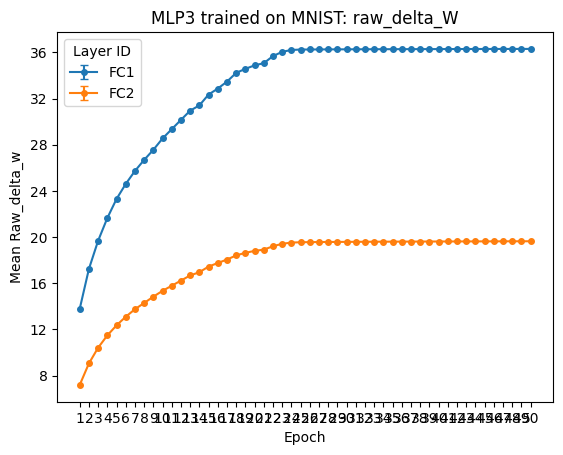

Plot saved as raw_delta_b.png


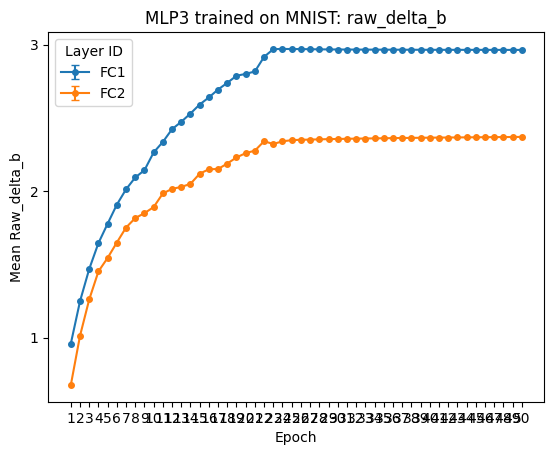

In [13]:
plot_metric(all_details, metric='norm') 

 ## Spectral-based Norms 

these norms depend on eigenvalues $\lambda$ 

$$\mathbf{X} = \frac{1}{N}\mathbf{W}^{\top}\mathbf{W}$$

$$\mathbf{X}\mathbf{v}=\lambda\mathbf{v}$$

#### dataframe columns

- **entropy** Matrix Entropy $H = -\sum p_i \ln p_i$ where $p_i = \frac{\lambda_i}{\sum \lambda}$
  
- **spectral norm:** Largest Eigenvalue $\;\;\Vert \mathbf{W}\Vert_{F}^{2}=\Vert \mathbf{X}\Vert_2 := \lambda_{\max}$<br>
   This depends on the scale / normalization of $\mathbf{X}$.
  
- **log spectral norm:**  $\;\;\log_{10}$(spectral norm)

- **stable rank:** Ratio of Frobenius norm to the Spectral norm $\;\;\mathcal{R}_{stable}
:= \frac{\Vert \mathbf{W}\Vert_{F}^2}{\Vert \mathbf{W}\Vert_{2}^2}
= \frac{\Vert \mathbf{X}\Vert_{F}}{\Vert \mathbf{X}\Vert_{2}}
= \frac{\sum \lambda}{\lambda_{max}} \ge 1
$

<hr>


Plot saved as entropy.png


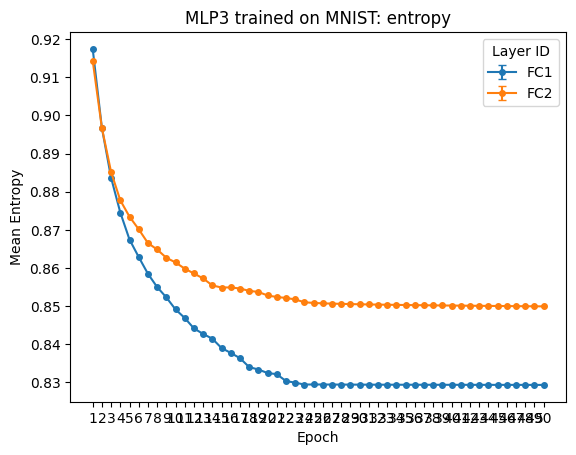

In [40]:
plot_metric(all_details, metric='entropy')  # Default settings, saves as entropy.png


#### Spectral Norm

Notice the largest eigenvalue increases, not decreases (as predicted by SLT), during  training

Plot saved as log_spectral_norm.png


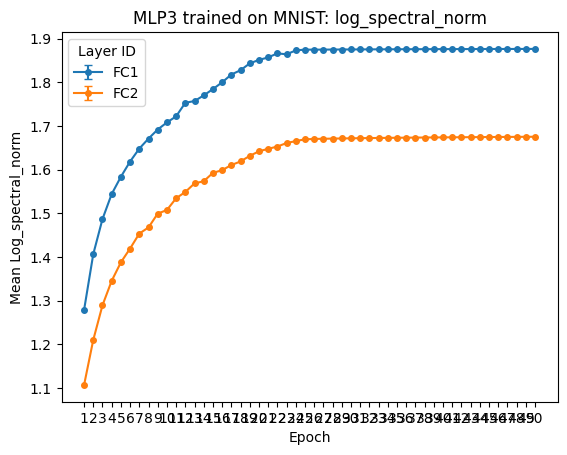

In [41]:
plot_metric(all_details, metric='log_spectral_norm')    # Will add a red dashed line at y=2.0

#### Stable Rank ?

Again-- so what ?

Plot saved as stable_rank.png


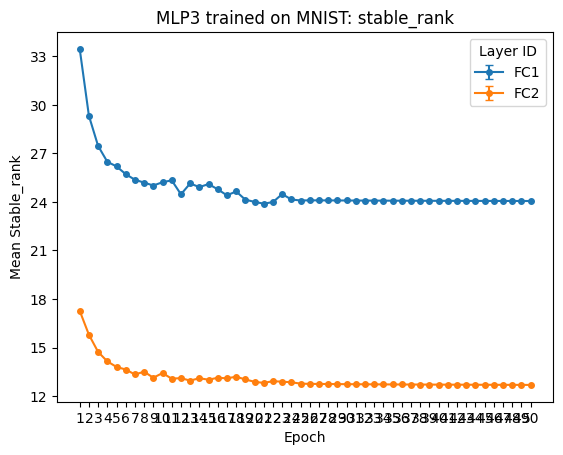

In [45]:
plot_metric(all_details, metric='stable_rank')    # Will add a red dashed line at y=2.0


## HTSR Metrics

See the HTSR JMLR paper: https://jmlr.org/papers/v22/20-410.html


weightwatcher compues the eigenvalues of each layer using SVD and then fits the empirical spectral density (ESD) to a power-law 

$$ \rho_{tail}(\lambda)\sim\lambda^{-\alpha}\;\;, \lambda\in[\lambda_{min},\lambda_{max}]$$

#### dataframe columns 
- **alpha:**  Power Law (PL) exponent $\;\;\alpha$

- **alpha_weighted:** Alpha-Hat $\;\;\alpha\log_{10}\lambda_{max}$ <br>
 (from Nature paper, depends on normalization of $\mathbf{W}$)

- **D:** KS-Distance, quality of PL fit $\;\;D_{KS}$

- **xmin:** Start of PL tail $\;\;\lambda_{min}$

- **num_pl_spikes:** Number of eigenvlaues in tail, $\;\;\text{count}(\lambda\ge\lambda_{min})$

- **ww_softrank:**  MP Softrank $\;\;\dfrac{\lambda_{min}}{\lambda^{+}}$ <br>
  (computed a little differently than the paper)

<hr>


Plot saved as alpha.png


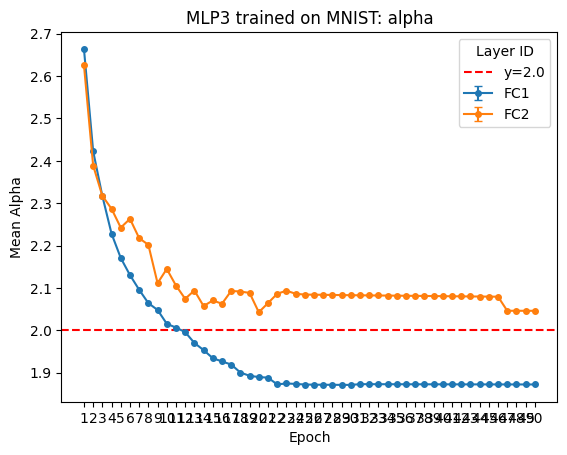

In [46]:
plot_metric(all_details, metric='alpha')    # Will add a red dashed line at y=2.0

### Num Pl Spikes

#### WW options (to visualize)

- mp_fit=True

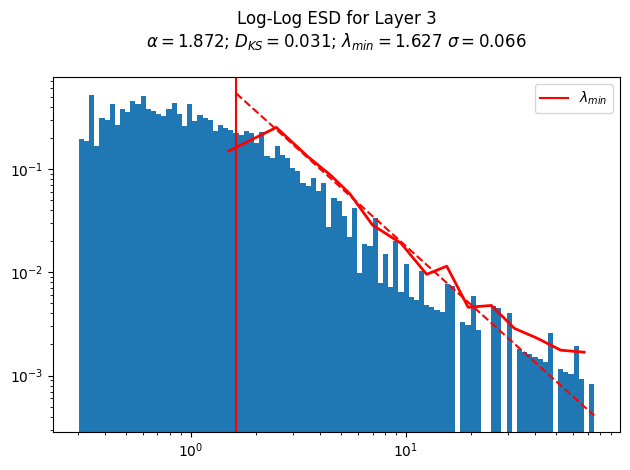

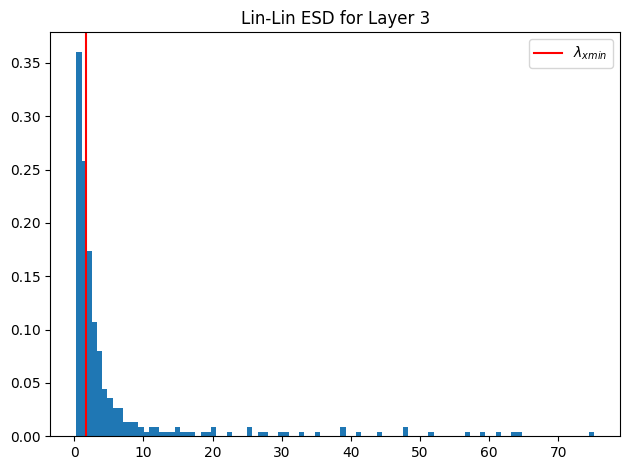

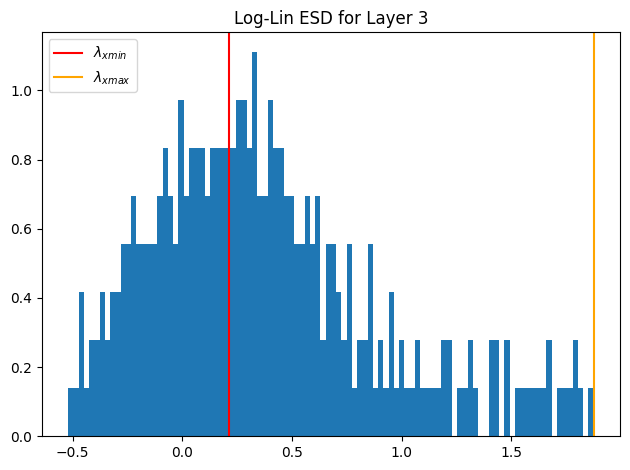

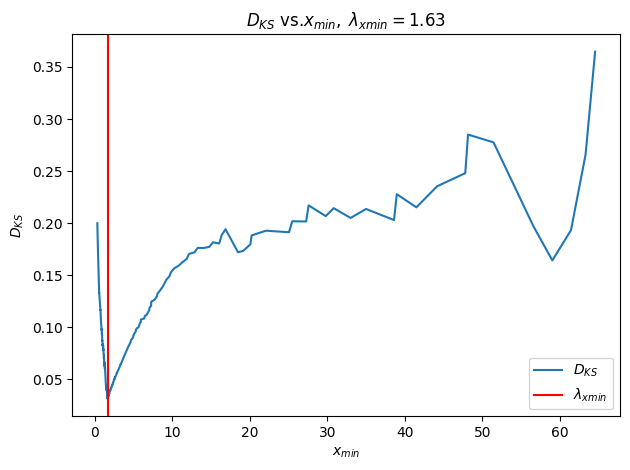

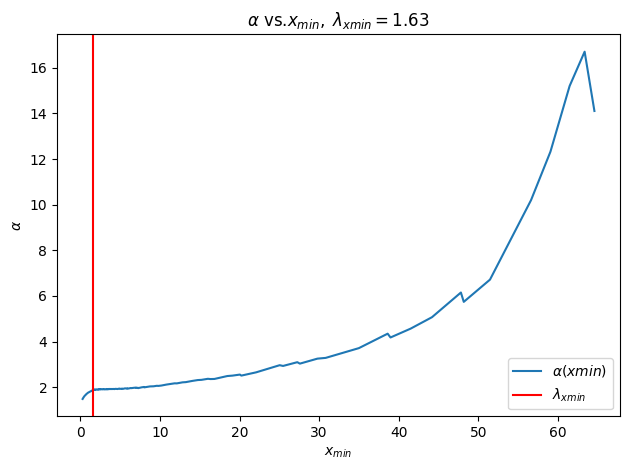

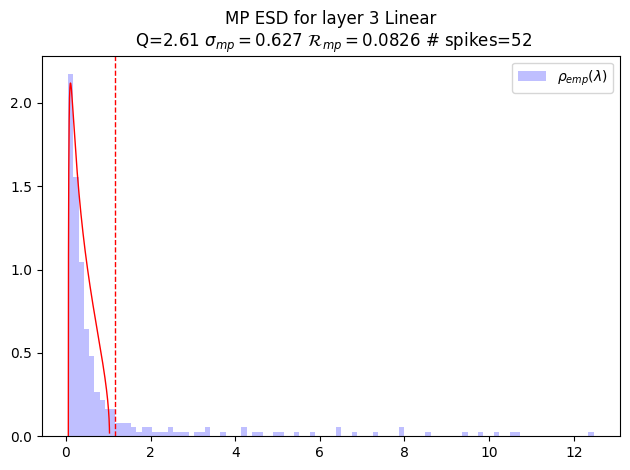

---------
 num PL spikes =  [175]


<Figure size 640x480 with 0 Axes>

In [62]:
df3 = watcher.analyze(layers=[3], plot=True, mp_fit=True)
print("---------\n num PL spikes = ",df3.num_pl_spikes.to_numpy())


Plot saved as num_pl_spikes.png


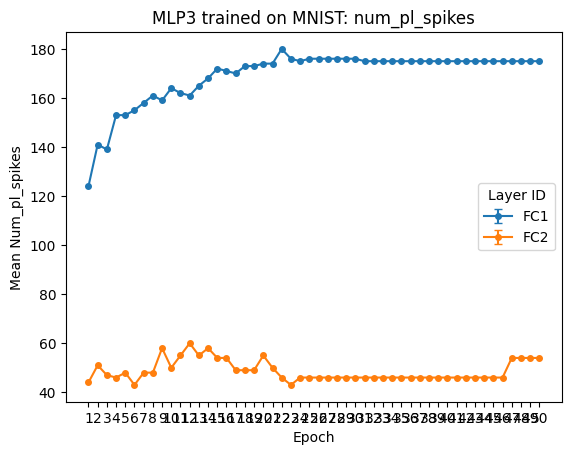

In [19]:
plot_metric(all_details, metric='num_pl_spikes')    


## SETOL metrics


The \emph{Effective Correlation Space} is defined by the \emph{TraceLog} condition <br>
(This also depends on normalizing $\mathbf{X}$ properly)

$$\mathbf{\tilde{X}}$$

$$Tr[\ln \mathbf{\tilde{X}}]=\ln \det \mathbf{\tilde{X}} = \ln \prod \tilde{\lambda}=0$$ where $$\tilde{\lambda}:=\lambda\ge\lambda^{ECS}_{min}$$

#### blog posts:
  
  - https://calculatedcontent.com/2023/02/01/deep-learning-and-effective-correlation-spaces/
- https://calculatedcontent.com/2024/12/24/weightwatcher-htsr-theory-and-the-renormalization-group/
  
#### dataframe columns
- **detX_num:** Number of eigenvlaues $\tilde{\lambda}$ in the ECS $\;\;\text{count}(\lambda\ge\lambda^{ECS}_{min})$

- **detX_val:** the value of $\lambda\ge\lambda^{ECS}_{min})$ <br>
  In the same units as xmin $(\lambda_{min})$ ?

<hr>

15(15

Plot saved as detX_num.png


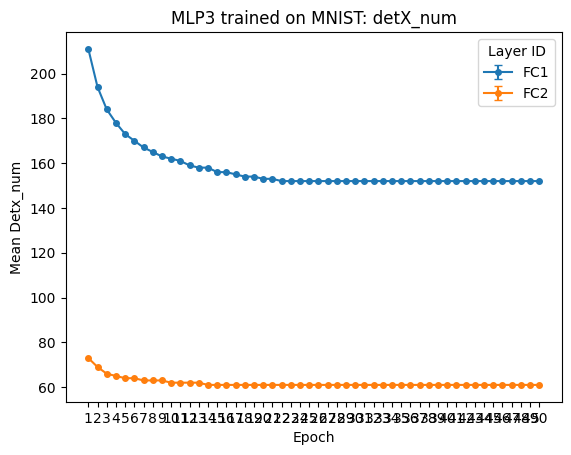

In [50]:
plot_metric(all_details, metric='detX_num')    

### Delta Num Spikes

Plot saved as delta_num_spikes.png


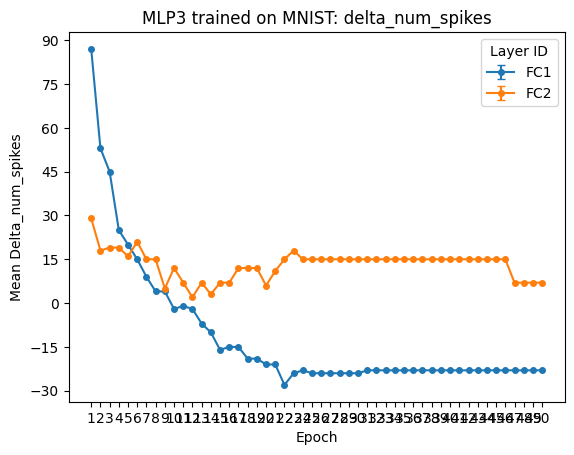

In [63]:
df0['delta_num_spikes']=df0.detX_num - df0.num_pl_spikes
plot_metric(all_details, metric='delta_num_spikes')    

### DragonKing metrics

#### blog posts: 
- https://calculatedcontent.com/2023/03/21/weightwatcher-advanced-features-fix_fingers/
- https://calculatedcontent.com/2024/01/29/evaluating-llms-with-weightwatcher-part-iii-the-magic-of-mistral-a-story-of-dragon-kings/

#### dataframe columns

- **raw_alpha:**   (PL) exponent $\;\;\alpha$ without fixed fingers

- **num_fingers:** Number of outlier eigenvlaues in tail $\;\;\text{count}(\lambda\ge\lambda_{max})$

<hr>


### Compare alpha to raw_alpha 

In [71]:
df0[df0.epoch==50]['alpha']

100    1.872230
101    2.046046
Name: alpha, dtype: float64

In [72]:
df0[df0.epoch==50]['raw_alpha']

100    1.872230
101    2.046046
Name: raw_alpha, dtype: float64

Plot saved as alpha.png


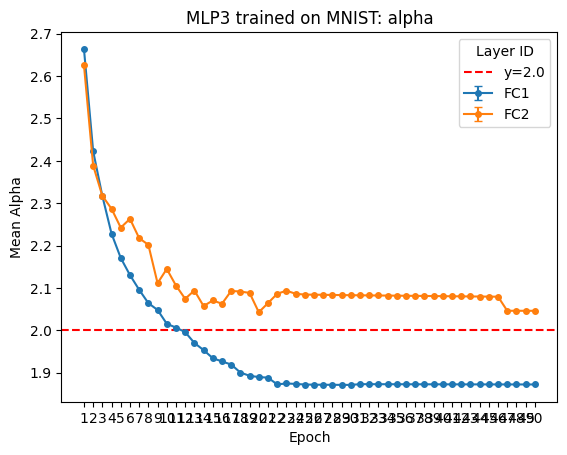

In [73]:
plot_metric(all_details, metric='alpha')    

Plot saved as raw_alpha.png


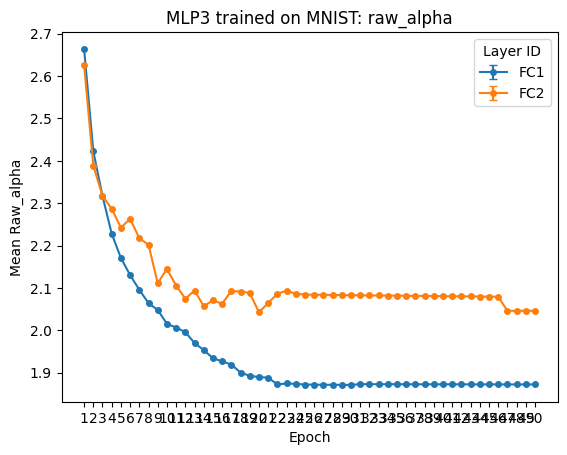

In [74]:
plot_metric(all_details, metric='raw_alpha')    